# Проект e-com

In [81]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
customers = pd.read_csv('olist_customers_dataset.csv')
customers.shape

(99441, 5)

In [83]:
orders = pd.read_csv('olist_orders_dataset.csv')
orders.shape

(99441, 8)

In [84]:
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_items.shape

(112650, 7)

## Таблица customers  —  таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

## Таблица orders  —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

## Таблица order_items — товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

In [85]:
orders.sample(5, random_state=0)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
36772,6b07198fae1bb61de16e845a92fc876f,92932704db71729a8f947b9ffdce4c99,delivered,2017-02-06 21:14:15,2017-02-06 21:25:13,2017-02-13 14:14:57,2017-02-17 12:11:59,2017-03-15 00:00:00
87203,5b9f98f4f7f84913dfb746a86bb11ab1,95879700e06973f767b965aa8972150b,delivered,2018-02-18 07:45:02,2018-02-18 07:55:21,2018-02-21 18:48:48,2018-04-03 22:47:23,2018-03-15 00:00:00
85028,66c8850e9f6bc2f81873165c41901706,b77e9f78e46a3fb8102d77740a2263da,delivered,2018-04-01 18:09:28,2018-04-01 18:27:51,2018-04-02 19:36:42,2018-04-03 12:22:34,2018-04-12 00:00:00
26166,c7ab4f518d1a47c3f78768c41c887d1b,f48f0e3bbe7fa6985141518b1d7264ce,delivered,2018-08-09 13:59:38,2018-08-11 02:55:27,2018-08-14 10:11:00,2018-08-27 20:04:23,2018-08-20 00:00:00
72312,0ff22bde315f6d0807028be76d9e736d,8125090a4744adfbe6d3940abeeb859b,delivered,2018-06-25 08:23:10,2018-06-27 09:11:47,2018-06-27 09:20:00,2018-07-05 12:36:25,2018-07-31 00:00:00


Переведем все колонки с датой из строчного типа в тип даты

In [86]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [87]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

In [88]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

Посмотрим какие статусы заказа существуют, чтобы определиться, что можно считать покупкой.

In [89]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

<b>Уникальные статусы заказов в таблице orders</b>:

created —  создан

approved —  подтверждён

invoiced —  выставлен счёт

processing —  в процессе сборки заказа

shipped —  отгружен со склада

delivered —  доставлен пользователю

unavailable —  недоступен

canceled —  отменён

Проверим сколько статусов заказа может быть присвоено одному customer_id

In [90]:
orders.groupby('customer_id').agg({'order_status':'nunique'}).query('order_status > 1')

,order_status
customer_id,


Покупкой будем считать заказ с одним из статусов: <b>delivered, approved, processing, shipped</b> - так как каждому заказу соответствует только один статус и можно считать покупкой доставленные, оплаченные, отгруженные заказы или заказы в процессе сборки

## 1. Сколько у нас пользователей, которые совершили покупку только один раз? 

In [91]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [92]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [93]:
customers_and_orders = customers.merge(orders, how='inner', on='customer_id')

In [94]:
customers_and_orders \
    .query('order_status in ("delivered", "approved", "processing", "shipped")') \
    .dropna()\
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id':'count'}).order_id.value_counts()

1     90536
2      2572
3       181
4        28
5         9
6         5
7         3
15        1
9         1
Name: order_id, dtype: int64

<b>90536</b> пользователей совершили покупку только один раз

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [95]:
orders['order_purchase_month'] = orders['order_purchase_timestamp'].to_numpy().astype('datetime64[M]')

In [96]:
not_delivered_orders = orders\
    .query('order_status in ("approved", "processing", "shipped")')\
    .groupby(['order_purchase_month', 'order_status'], as_index=False)\
    .agg({'order_id': 'count'})

In [97]:
not_delivered_orders.head()

,order_purchase_month,order_status,order_id
0,2016-09-01,shipped,1
1,2016-10-01,processing,2
2,2016-10-01,shipped,8
3,2017-01-01,processing,9
4,2017-01-01,shipped,16


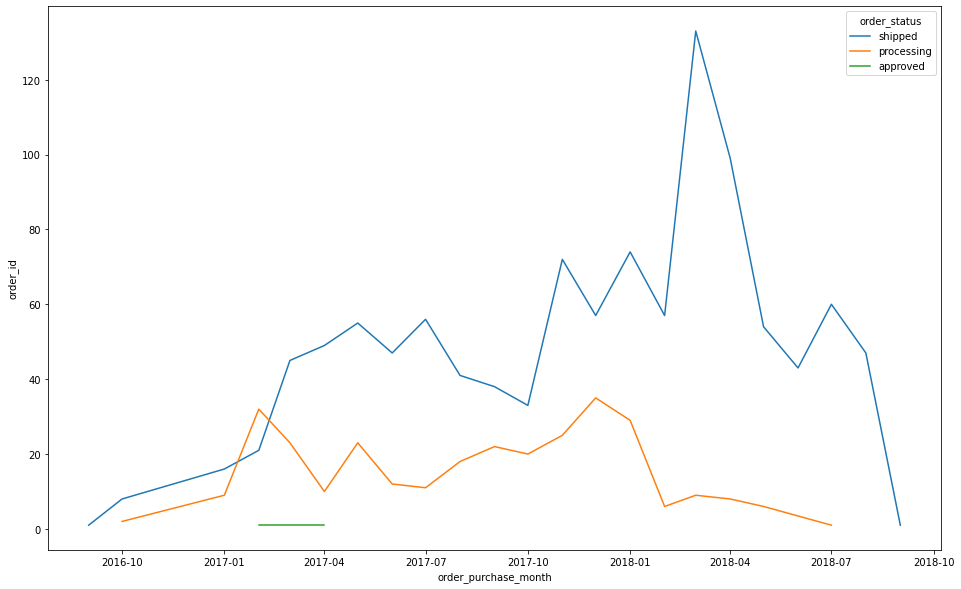

In [98]:
plt.figure(figsize=(16,10))
sns.lineplot(x='order_purchase_month', y='order_id', hue='order_status', data=not_delivered_orders)

Как видно из графика в основном заказ только отгружен со склада

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [99]:
products_in_orders = orders.merge(order_items, how='right', on='order_id')

In [100]:
products_in_orders.sample(5, random_state=0)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
111764,fde2b2f46bb69e2359b74ff7606de899,077e8825452efc8df7289444b1226930,delivered,2017-06-23 21:07:46,2017-06-23 21:23:09,2017-06-27 10:04:26,2017-07-03 13:22:08,2017-07-13,2017-06-01,1,faec279ddbbce3de75d2adf10f612a5e,e26901d5ab434ce92fd9b5c256820a4e,2017-06-28 21:23:09,119.90,16.47
61080,8b378967566499beb14fbb0fc0edd2ed,64befe40ea8fa23ae79c102633305671,delivered,2018-06-26 18:25:34,2018-06-26 18:43:53,2018-06-27 08:35:00,2018-06-28 16:58:50,2018-07-13,2018-06-01,1,7329d78e4f4ab3101c7e5fc53fb0aebb,40d54b51e962dbe09cabbcfd33298dee,2018-07-02 18:43:53,399.00,11.54
70265,a04b6ad9c324577c000835fca4587931,84da725dbe39aa4d9c3005e868b26b0c,delivered,2018-02-08 08:43:00,2018-02-09 02:50:32,2018-02-19 15:09:22,2018-02-27 18:51:20,2018-03-07,2018-02-01,1,dc9471db933efad7bf0ce685380578bd,25c5c91f63607446a97b143d2d535d31,2018-02-15 02:50:32,276.89,19.19
30502,453c6f368bd52d7a2c03f6cc81ccf9d8,511ef0347dfb82cddc47df9a7dbd6c64,delivered,2017-11-04 10:25:02,2017-11-04 10:36:10,2017-11-06 20:48:36,2017-11-09 16:56:51,2017-11-24,2017-11-01,1,7b2c4d6fa7d8e50000ac4c7fca609790,f262cbc1c910c83959f849465454ddd3,2017-11-09 10:35:40,35.99,11.85
6490,0eb90012b8c41dfd386552415c3b1760,6f380f1105060ce0abf373c93619c6ee,delivered,2018-05-08 09:03:53,2018-05-08 09:15:19,2018-05-14 09:30:00,2018-05-24 21:21:29,2018-06-08,2018-05-01,1,41db6d8062fcd38410c699743ccc0265,92eb0f42c21942b6552362b9b114707d,2018-05-16 09:15:19,13.77,16.41


In [101]:
products_in_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_purchase_month           112650 non-null  datetime64[ns]
 9   order_item_id                  112650 non-null  int64         
 10  product_id                     112650 non-null  object        
 11  

In [102]:
products_in_orders['weekday'] = products_in_orders.order_approved_at.dt.day_name()

In [103]:
prods_bought_by_weekday = products_in_orders\
    .query('order_status in ("delivered", "approved", "processing", "shipped")')\
    .groupby(['order_item_id', 'weekday'], as_index=False)\
    .agg({'order_id': 'count'}).rename(columns={'order_id': 'order_count'})

In [104]:
prods_bought_by_weekday['is_maximum'] = np.where(
                                            prods_bought_by_weekday.index.isin(
                                                    (prods_bought_by_weekday.groupby('order_item_id')['order_count'].idxmax())
                                                ), 1, 0)

In [105]:
prods_bought_by_weekday.query('is_maximum == 1')

,order_item_id,weekday,order_count,is_maximum
5,1,Tuesday,18883,1
12,2,Tuesday,1930,1
19,3,Tuesday,457,1
26,4,Tuesday,176,1
33,5,Tuesday,87,1
39,6,Thursday,54,1
44,7,Saturday,10,1
49,8,Friday,8,1
56,9,Friday,7,1
63,10,Friday,6,1


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [106]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-01
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08-01
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11-01
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02-01


In [107]:
customers_and_orders = customers.merge(orders, how='inner', on='customer_id')

In [108]:
customers_and_orders['order_approved_month'] = customers_and_orders['order_approved_at'].to_numpy().astype('datetime64[M]')

In [109]:
customers_and_orders['weeks_in_month'] = customers_and_orders.order_approved_month.dt.days_in_month / 7

In [110]:
customer_order_count_by_month = customers_and_orders\
    .query('order_status in ("delivered", "approved", "processing", "shipped")')\
    .groupby(['customer_unique_id', 'order_approved_month', 'weeks_in_month'], as_index=False)\
    .agg({'order_id': 'count'}).rename(columns={'order_id': 'order_count'})

In [111]:
customer_order_count_by_month['avg_order_by_cust'] = customer_order_count_by_month.order_count / customer_order_count_by_month.weeks_in_month

Проверим, что считаем именно по месяцам

In [112]:
customer_order_count_by_month.query('customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"')

,customer_unique_id,order_approved_month,weeks_in_month,order_count,avg_order_by_cust
53192,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-01,4.428571,1,0.225806
53193,8d50f5eadf50201ccdcedfb9e2ac8455,2017-06-01,4.285714,1,0.233333
53194,8d50f5eadf50201ccdcedfb9e2ac8455,2017-07-01,4.428571,2,0.451613
53195,8d50f5eadf50201ccdcedfb9e2ac8455,2017-08-01,4.428571,1,0.225806
53196,8d50f5eadf50201ccdcedfb9e2ac8455,2017-09-01,4.285714,1,0.233333
53197,8d50f5eadf50201ccdcedfb9e2ac8455,2017-10-01,4.428571,2,0.451613
53198,8d50f5eadf50201ccdcedfb9e2ac8455,2017-11-01,4.285714,1,0.233333
53199,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05-01,4.428571,2,0.451613
53200,8d50f5eadf50201ccdcedfb9e2ac8455,2018-07-01,4.428571,2,0.451613
53201,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08-01,4.428571,3,0.677419


In [113]:
customer_order_count_by_month.avg_order_by_cust.value_counts()

0.225806    58141
0.233333    29196
0.250000     7937
0.451613      726
0.466667      330
0.500000      161
0.677419       25
0.700000       13
0.750000        6
1.000000        3
0.903226        2
0.933333        2
1.354839        1
Name: avg_order_by_cust, dtype: int64

## 5. Когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц

In [114]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-01
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08-01
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11-01
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02-01


In [115]:
orders.order_approved_at.describe(datetime_is_numeric=True)

count                            99281
mean     2017-12-31 18:35:24.098800384
min                2016-09-15 12:16:38
25%                2017-09-12 23:24:16
50%                2018-01-19 11:36:13
75%                2018-05-04 20:35:10
max                2018-09-03 17:40:06
Name: order_approved_at, dtype: object

Возьмем наблюдения за 2017 год, так так только он содержит все месяцы с января по декабрь. Так же добавим туда наблюдения за 2018 год до 1 апреля, т.е. возьмем запас в 3 месяца для людей, совершивших покупку в конце 2017 года

In [117]:
cohort_data = orders.copy()
cohort_data = cohort_data\
    [cohort_data.order_purchase_timestamp.between('2017-01-01', '2018-04-01')]\
    .query('order_status in ("delivered", "approved", "processing", "shipped")')\
    .reset_index(drop=True)\
    .dropna()

In [118]:
cohort_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-01
1,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11-01
2,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02-01
3,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,2017-07-01
4,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,2017-05-01


In [119]:
cohort_data = cohort_data.merge(customers, how="inner", on='customer_id')

In [120]:
unique_customers = cohort_data.customer_unique_id.nunique()
unique_customers

62026

Оставим только нужные колонки. Будем рассматривать когорты покупателей по месяцам, городам и штатам

In [121]:
cohort_data = cohort_data[['customer_unique_id', 'order_id', 'order_approved_at', 'customer_city', 'customer_state']]\
    .sort_values('order_approved_at')

In [122]:
cohort_data.head()

,customer_unique_id,order_id,order_approved_at,customer_city,customer_state
50725,f7b981e8a280e455ac3cbe0d5d171bd1,ec7a019261fce44180373d45b442d78f,2017-01-05 12:10:17,curitiba,PR
39209,4b3207464f5f7a48a7f63fa0b1251d86,e1fe072ef14b519af1f0a8ed997c1301,2017-01-05 16:15:16,ribeirao preto,SP
3837,b88b78a413e70182e18b032361b24f91,f2dd5f15184c73c0d45c02941c7c23d1,2017-01-05 23:05:27,irece,BA
15545,48368b31672665cca1b8a03047a1702a,157ec3dc3f38cdbd2706bd216edfe8fb,2017-01-06 13:55:11,santa luzia,MG
60918,c9517b423493063fa4e805acf2cc4564,e6db6e9529fecbe14cd05dd349816656,2017-01-06 21:35:20,lagoa santa,MG


In [361]:
# cohort_data['approved_2nd_month'] = cohort_data.order_approved_at + pd.DateOffset(months=2)
# cohort_data['approved_3d_month'] = cohort_data.order_approved_at + pd.DateOffset(months=3)

Добавим к каждой строке столбца дату первой покупки клиента

In [124]:
start_date = cohort_data.groupby('customer_unique_id')['order_approved_at'].min().rename('start_date')
cohort_data = pd.merge(cohort_data, start_date, left_on='customer_unique_id', right_index=True)

In [125]:
cohort_data['start_month'] = cohort_data['start_date'].to_numpy().astype('datetime64[M]')

Высчитаем через сколько месяцев клиент снова совершил покупку

In [128]:
cohort_data['returned_months'] = (cohort_data.order_approved_at - cohort_data.start_date)/np.timedelta64(1, 'M')

In [132]:
cohort_data.sample(5, random_state=0)

,customer_unique_id,order_id,order_approved_at,customer_city,customer_state,start_date,start_month,returned_months
36777,b8cfc2f993591e07f2b5ee5fdc912840,ee4777f7cd28163d7b1b9f1763996e08,2017-11-25 03:52:15,caxambu,MG,2017-11-25 03:52:15,2017-11-01,0.0
62982,73db255b34a3bb4f6b591ede69c80dc7,11de19a6b9ccdeeb0b0ef48d91cfd78b,2017-10-29 17:24:56,curitiba,PR,2017-10-29 17:24:56,2017-10-01,0.0
62521,e601188dfe8db2615145f9466aaa8a39,268836b1aa282605cf690e10defb2b35,2018-03-01 02:48:59,braganca paulista,SP,2018-03-01 02:48:59,2018-03-01,0.0
51744,c8060d3780dc605de76f35961e0bf2da,ef31025693a0212c0b45d12f12f12a5e,2018-02-20 11:47:44,sao paulo,SP,2018-02-20 11:47:44,2018-02-01,0.0
37248,21ff6b67205558381cfbec10ee2fa4e0,cf774fe62d37125e7b9638ef68f872b6,2017-12-27 07:27:54,salvador,BA,2017-12-27 07:27:54,2017-12-01,0.0


Оставим только тех покупателей, что совершили покупку на 3й месяц

In [134]:
customers_returned_on_3d_month = cohort_data.query('2 < returned_months < 3')

In [135]:
customers_returned_on_3d_month.head()

,customer_unique_id,order_id,order_approved_at,customer_city,customer_state,start_date,start_month,returned_months
847,a5c806ebe5b25d0ab1e7f0da0e17d6bc,e1215367814d0d82c496bf4c6b2ba6f7,2017-04-13 20:22:03,sao bernardo do campo,SP,2017-02-01 22:41:28,2017-02-01,2.329516
20685,e5bdbd18812e42788e7cbad7058fc0ab,8eaff5985d99ef7dd4578cbdc31b430f,2017-04-25 13:42:18,niteroi,RJ,2017-02-04 11:55:21,2017-02-01,2.630831
51179,7ee9e6c80bf1b7ec4a52639eab6c128c,c92c52fc8165c38e21adf26ffcf62028,2017-05-03 11:34:39,campinas,SP,2017-02-26 20:01:53,2017-02-01,2.156849
41069,bf6656ef50e6fd00e7517b01d615b4f3,5cddc0e7aa59980c2f6018bbbde4b776,2017-05-26 07:15:11,vila velha,ES,2017-03-01 10:05:20,2017-03-01,2.821638
59477,336421b86cc4259a58106da261e0e000,1e80bd664bc120ddf4d789b7b9455e14,2017-05-11 04:02:44,rio de janeiro,RJ,2017-03-04 02:23:28,2017-03-01,2.236397


In [139]:
def retention_by_cohort(df: pd.DataFrame, cohort: str):
    df = df\
        .groupby(cohort, as_index=False)\
        .agg({'customer_unique_id': 'nunique'})\
        .rename(columns={'customer_unique_id': 'cust_count'})\
        .sort_values('cust_count', ascending=False)

    df['retention'] = df.cust_count / unique_customers  
    
    return df

In [147]:
cohort_by_city = retention_by_cohort(customers_returned_on_3d_month, 'customer_city')
cohort_by_city.head()

,customer_city,cust_count,retention
66,sao paulo,24,0.000387
53,rio de janeiro,8,0.000129
14,campinas,4,0.000064
60,santo andre,4,0.000064
78,vitoria,4,0.000064


In [146]:
cohort_by_city_state = retention_by_cohort(customers_returned_on_3d_month, 'customer_state')
cohort_by_city_state.head()

,customer_state,cust_count,retention
15,SP,68,0.001096
9,RJ,16,0.000258
4,MG,15,0.000242
12,RS,11,0.000177
2,ES,8,0.000129


In [148]:
cohort_by_started_month = retention_by_cohort(customers_returned_on_3d_month, 'start_month')
cohort_by_started_month.head()

,start_month,cust_count,retention
7,2017-09-01,19,0.000306
10,2017-12-01,18,0.000290
9,2017-11-01,17,0.000274
1,2017-03-01,14,0.000226
4,2017-06-01,14,0.000226


Как видно самый большой retention показывает когорта по штатам

## 6. Построить RFM-сегментацию пользователей. 
R - время от последней покупки пользователя до текущей даты, 

F - суммарное количество покупок у пользователя за всё время, 

M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры.

Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [151]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-01
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08-01
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11-01
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02-01


In [152]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Создадим фрэйм для RFM-сегментации

In [153]:
rfm_segmentation_df = orders.merge(customers, on='customer_id').merge(order_items, on='order_id')

In [154]:
rfm_segmentation_df = rfm_segmentation_df\
    .query('order_status in ("delivered", "approved", "processing", "shipped")')\
    .reset_index(drop=True)\
    .dropna()

In [155]:
rfm_segmentation_df = rfm_segmentation_df[['order_id', 'order_approved_at', 'customer_unique_id', 'price']]

In [156]:
rfm_segmentation_df = rfm_segmentation_df\
    .groupby(['customer_unique_id', 'order_id', 'order_approved_at'], as_index=False)\
    .agg({'price':'sum'})

In [157]:
rfm_segmentation_df.head()

,customer_unique_id,order_id,order_approved_at,price
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 11:11:18,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 18:25:44,18.90
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:49:17,25.99
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 20:06:52,180.00


Будем считать, что сейчас следующий день после последнего для наблюдений

In [158]:
now = rfm_segmentation_df.order_approved_at.max() + pd.Timedelta("1 days")
now

Timestamp('2018-08-30 15:10:26')

In [159]:
rfm_segmentation_df['recency'] = rfm_segmentation_df['order_approved_at']\
    .apply(lambda x: (now - x).days)

In [160]:
rfm_segmentation_df.head()

,customer_unique_id,order_id,order_approved_at,price,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 11:11:18,129.90,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 18:25:44,18.90,114
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,69.00,537
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:49:17,25.99,321
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 20:06:52,180.00,288


In [161]:
rfm_segmentation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96455 entries, 0 to 96454
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_unique_id  96455 non-null  object        
 1   order_id            96455 non-null  object        
 2   order_approved_at   96455 non-null  datetime64[ns]
 3   price               96455 non-null  float64       
 4   recency             96455 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 4.4+ MB


Высчитаем параметры RFM

In [162]:
rfm_segmentation_df = rfm_segmentation_df\
    .groupby('customer_unique_id', as_index=False)\
    .agg({'recency':'min', 'order_id': 'count', 'price':'sum'})\
    .rename(columns={'order_id': 'frequency', 'price':'monetary'})

In [163]:
rfm_segmentation_df

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,1570.00
93332,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
93333,ffff371b4d645b6ecea244b27531430a,568,1,89.90
93334,ffff5962728ec6157033ef9805bacc48,119,1,115.00


Пора определить границы сегментов

In [164]:
rfm_segmentation_df.describe()

,recency,frequency,monetary
count,93336.000000,93336.000000,93336.000000
mean,237.486093,1.033417,141.621663
std,152.569986,0.209098,215.714143
min,1.000000,1.000000,0.850000
25%,114.000000,1.000000,47.650000
50%,219.000000,1.000000,89.700000
75%,346.000000,1.000000,154.692500
max,714.000000,15.000000,13440.000000


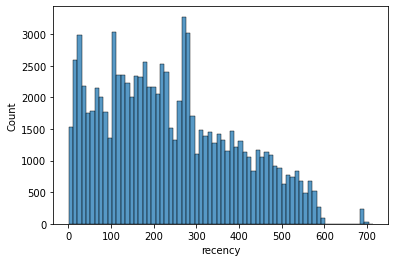

In [165]:
sns.histplot(rfm_segmentation_df.recency);

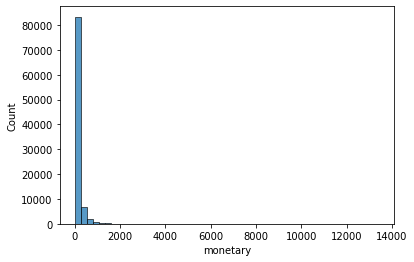

In [166]:
sns.histplot(rfm_segmentation_df.monetary, bins=50);

In [167]:
quintiles = rfm_segmentation_df[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 92.0, 0.4: 177.0, 0.6: 268.0, 0.8: 382.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

In [168]:
rfm_segmentation_df.frequency.value_counts()

1     90536
2      2572
3       181
4        28
5         9
6         5
7         3
15        1
9         1
Name: frequency, dtype: int64

Для <b>Recency</b> (используя квантили):

1 - (382; ...)

2 - [382; 268)

3 - [268; 177)

4 - [177; 92)

5 - [92; 0]

Для <b>Monetary</b> (используя квантили):

1 - (179.9; ...)

2 - [179.9; 109.9)

3 - [109.9; 69.9)

4 - [69.9; 39.9)

5 - [39.9; 0]

Для <b>Frequency</b> оценки квантили не помогут, поэтому:

1 - 1

2 - 2

3 - 3

4 - [4; 5]

5 - [6; 15]

Так как очень много клиентов заказывали один раз. Столкнулись с одним из <b>недостатков</b> RFM: может быть неприменима в отраслях, где заказчики обычно являются разовыми покупателями.

Определим для клиентов их сегмент

In [169]:
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quintiles['monetary'][.2]:
        return 1
    elif x <= quintiles['monetary'][.4]:
        return 2
    elif x <= quintiles['monetary'][.6]:
        return 3
    elif x <= quintiles['monetary'][.8]:
        return 4
    else:
        return 5    
    
def f_score(x):
    if x <= 1:
        return 1
    elif x <= 2:
        return 2
    elif x <= 3:
        return 3
    elif x <= 5:
        return 4
    else:
        return 5  

In [170]:
rfm_segmentation_df['R'] = rfm_segmentation_df['recency'].apply(lambda x: r_score(x))
rfm_segmentation_df['F'] = rfm_segmentation_df['frequency'].apply(lambda x: f_score(x))
rfm_segmentation_df['M'] = rfm_segmentation_df['monetary'].apply(lambda x: m_score(x))

In [171]:
rfm_segmentation_df['RFM'] = rfm_segmentation_df['R'].map(str) + rfm_segmentation_df['F'].map(str) + rfm_segmentation_df['M'].map(str)

In [172]:
# rfm_segmentation_df['RFM'] = rfm_segmentation_df['RFM'].astype('int32')

In [173]:
rfm_segmentation_df.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,215


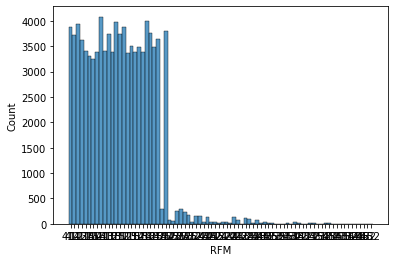

In [176]:
sns.histplot(rfm_segmentation_df.RFM)

Найдем RFM сегменты, встречающиеся чаще всего

In [181]:
rfm_segmentation_df\
    .groupby('RFM', as_index=False)\
    .agg({'customer_unique_id': 'count'})\
    .query('customer_unique_id > 3000')

,RFM,customer_unique_id
0,111,4080
1,112,3939
2,113,3390
3,114,3240
4,115,3512
19,211,3614
20,212,4001
21,213,3406
22,214,3380
23,215,3401
